In [1]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class StoppingPowerFile:
    def __init__(self, filename):
        """
filename: Name of file containing stopping power as a function of energy.
Assuming that the first column is energy, second is stopping power.
        """
        infile = open(filename, 'r')
        lines = infile.readlines()
        infile.close()
        data = []
        for line in lines: data.append(line.split())

        self.x = array([float(data[i][0]) for i in range(len(data))])
        self.y = array([float(data[i][1]) for i in range(len(data))])
        
    def __call__(self, E, factor):
        # Interpolates between the points and calculates at energy E.
        return factor*interp(E, self.x, self.y, left=1e16, right=self.y[-1])
    def Loss(self, E, width, n):
        """
Function to calculate the energy loss experienced by a particle
traveling through the material with stopping power extracted from
the input file.
E: Initial energy of the particle.
width: The width of the material.
n: Number of point to use in the RK4 algorithm.
        """
        Eafter = 0
        try:
            if width == 0: return copy(E)

            # Making sure we do not overwrite E!
            Eafter = copy(E)
        except:
            if width == 0: return E
            
            # Making sure we do not owerwrite
            Eafter = E
        
        # Step size.
        dx = width/float(n-1)

        # Solving the energy loss using Runge-Kutta 4.
        for i in range(0, n):
            R1 = dx*self(Eafter, -1)
            R2 = dx*self(Eafter + 0.5*R1, -1)
            R3 = dx*self(Eafter + 0.5*R2, -1)
            R4 = dx*self(Eafter + R3, -1)
            Eafter += (R1 + 2*R2 + 2*R3 + R4)/6.0
        # Negative energy is unphysical, setting all negative
        # values to zero.
        Eafter[Eafter<0] = 0.
        return Eafter
    
    def Gain(self, E, width, n):
        """
Function to calculate the initial energy that a particle would have
if it has energy E after moving through a material with some width.
E: Energy after the material.
width: The width of the material.
n: Number of points to be used in the RK4 algorithm.
        """
        
        Eafter = 0
        try:
            if width == 0: return copy(E)

            # Making sure we do not overwrite E!
            Eafter = copy(E)
        except:
            if width == 0: return E
            
            # Making sure we do not owerwrite
            Eafter = E

            # Step size.
        dx = width/float(n-1)

        # Solving the energy using Runge-Kutta 4.
        for i in range(0, n):
            R1 = dx*self(Eafter, +1)
            R2 = dx*self(Eafter + 0.5*R1, +1)
            R3 = dx*self(Eafter + 0.5*R2, +1)
            R4 = dx*self(Eafter + R3, +1)
            Eafter += (R1 + 2*R2 + 2*R3 + R4)/6.0

        # Negative energy is unphysical, setting all
        # negative values to zero.
        try:
            Eafter[Eafter<0] = 0.
        except:
            if Eafter < 0 or Eafter != Eafter: Eafter = 0.
        return Eafter
    def GainGrid(self, E, width, n):
        dx = width/float(n-1)        
        for i in range(0, n):
            R1 = dx*self(E, +1)
            R2 = dx*self(E + 0.5*R1, +1)
            R3 = dx*self(E + 0.5*R2, +1)
            R4 = dx*self(E + R3, +1)
            E += (R1 + 2*R2 + 2*R3 + R4)/6.0
        return E
    def LossGrid(self, E, width, n):
        dx = width/float(n-1)        
        for i in range(0, n):
            R1 = dx*self(E, -1)
            R2 = dx*self(E + 0.5*R1, -1)
            R3 = dx*self(E + 0.5*R2, -1)
            R4 = dx*self(E + R3, 1)
            E += (R1 + 2*R2 + 2*R3 + R4)/6.0
        return E
    
    
def Excitation(m1, m2, m3, m4, T2, T3, theta3):
    
    s = (m1 + m2)**2 + 2*m1*T2
    
    pcm = sqrt(((s - m1**2 - m2**2)**2 - (2*m1*m2)**2)/(4*s))
    
    chi = log((pcm + sqrt(m1**2 + pcm**2))/m1)

    p3 = sqrt(T3**2 + 2*m3*T3)
    
    E3cm = sqrt(p3**2 + m3**2)*cosh(chi) - p3*cos(theta3)*sinh(chi)
    Ex = sqrt(s - 2*sqrt(s)*E3cm + m3**2) - m4
    
    return Ex

def T3Energy(m1, m2, m3, m4, T2, ex, theta3):
    m4eff = m4 + ex
    s = (m1 + m2)**2 + 2*m1*T2
    
    pcm = sqrt(((s - m1**2 - m2**2)**2 - (2*m1*m2)**2)/(4*s))
    
    chi = log((pcm + sqrt(m1**2 + pcm**2))/m1)

    pcmprime = sqrt(((s - m3**2 - m4eff**2)**2 - (2*m3*m4eff)**2)/(4*s))
    
    E3p = sqrt(pcmprime**2 + m3**2)
    p3 = E3p*cos(theta3)*sinh(chi)+sqrt(pcmprime**2 - (m3*sin(theta3)*sinh(chi))**2)
    p3 /= (1. + (sin(theta3)*sinh(chi))**2)
    
    E3lab = sqrt(p3**2 + m3**2)
    return E3lab - m3

def ScatteringAngle(ringNo, R, innerR, ringPitch, ringWidth):
    
    # The middle of the ring is at:
    rMid = innerR + (ringNo+1)*ringWidth/2.
    
    # The inner & outer radius of the ring is:
    rInn = rMid - ringPitch/2.
    rOut = rMid + ringPitch/2.
    
    # Angles:
    
    theta = arcsin(rMid/sqrt(R**2 + rMid**2))
    thetaInn = arcsin(rInn/sqrt(R**2 + rInn**2))
    thetaOut = arcsin(rOut/sqrt(R**2 + rOut**2))
    
    return theta, thetaInn, thetaOut

def ReadStates(filename):
    infile = open(filename, "r")
    lines = infile.readlines()
    infile.close()
    data = []
    for line in lines: data.append(float(line))
    return array(data)

def SimulateNiPP(Ebeam, Twidth, Fwidth, dEwidth, Ewidth, reactionPoint, ex, theta):
    """
    Ebeam: energy of the incomming beam in MeV
    Twidth: Thickness of the target in g/cm2
    Fwidth: Thickness of the absorber in um
    dEwidth: Thickness of the dE detector in um
    Ewidth: Thickness of the E detector in um
    reactionPoint: Fraction of target thickness where the reaction will take place.
    ex: Array with excitation energy.
    theta: Angle of outgoing ion.
    """
    
    # Define masses
    m1 = 63.9279660*931.494061 # Mass nickel 64
    m2 = 1.008*931.494061 # Proton mass
    
    # Required stopping power
    stopTargetP = StoppingPowerFile("protonNi.txt")
    stopAbsorberP = StoppingPowerFile("SpAl_table_um.txt")
    stopTelescopeP = StoppingPowerFile("SpSi_table_um.txt")
    
    # First we calculate the point where the interaction will happend.
    thick_react = Twidth*reactionPoint # reactionPoint is a number between 0 and 1.
    
    Ereaction = Ebeam
    # Two special cases.
    if reactionPoint > 0 and reactionPoint < 1:
        Ereaction = stopTargetP.Loss(Ebeam, thick_react, 1001)
        Ereaction = T3Energy(m1, m2, m2, m1, Ereaction, ex, theta)
        Ereaction = stopTargetP.Loss(Ereaction, (Twidth-thick_react)/cos(theta), 1001)
    elif reactionPoint == 1:
        Ereaction = stopTargetP.Loss(Ebeam, Twidth, 1001)
        Ereaction = T3Energy(m1, m2, m2, m1, Ereaction, ex, theta)
    elif reactionPoint == 0:
        Ereaction = T3Energy(m1, m2, m2, m1, Ereaction, ex, theta)
        Ereaction = stopTargetP.Loss(Ereaction, Twidth/cos(theta), 1001)
    else:
        print "Error: reactionPoint is not within range [0, 1]"
        return 0, 0
    
    EaA = stopAbsorberP.Loss(Ereaction, Fwidth/cos(theta), 1001)
    EaDE = stopTelescopeP.Loss(EaA, dEwidth/cos(theta), 1001)
    EaE = stopTelescopeP.Loss(EaDE, Ewidth/cos(theta), 1001)
    EinDE = EaA - EaDE
    EinE = EaDE - EaE
    return EinE, EinDE

def SimulateNiPD(Ebeam, Twidth, Fwidth, dEwidth, Ewidth, reactionPoint, ex, theta):
    """
    Ebeam: energy of the incomming beam in MeV
    Twidth: Thickness of the target in g/cm2
    Fwidth: Thickness of the absorber in um
    dEwidth: Thickness of the dE detector in um
    Ewidth: Thickness of the E detector in um
    reactionPoint: Fraction of target thickness where the reaction will take place.
    ex: Array with excitation energy.
    theta: Angle of outgoing ion.
    """
    
    # Define masses
    m1 = 63.9279660*931.494061 # Mass nickel 64
    m2 = 1.008*931.494061 # Proton mass
    m3 = 2.014*931.494061 # Deuteron mass
    m4 = 62.9296694*931.494061 # Mass nickel 63
    
    # Required stopping power
    stopTargetP = StoppingPowerFile("protonNi.txt")
    stopTargetD = StoppingPowerFile("duteronNi.txt")
    stopAbsorberD = StoppingPowerFile("SdAl_table_um.txt")
    stopTelescopeD = StoppingPowerFile("SdSi_table_um.txt")
    
    # First we calculate the point where the interaction will happend.
    thick_react = Twidth*reactionPoint # reactionPoint is a number between 0 and 1.
    
    Ereaction = Ebeam
    # Two special cases.
    if reactionPoint > 0 and reactionPoint < 1:
        Ereaction = stopTargetP.Loss(Ebeam, thick_react, 1001)
        Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
        Ereaction = stopTargetD.Loss(Ereaction, (Twidth-thick_react)/cos(theta), 1001)
    elif reactionPoint == 1:
        Ereaction = stopTargetP.Loss(Ebeam, Twidth, 1001)
        Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
    elif reactionPoint == 0:
        Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
        Ereaction = stopTargetD.Loss(Ereaction, Twidth/cos(theta), 1001)
    else:
        print "Error: reactionPoint is not within range [0, 1]"
        return 0
    
    EaA = stopAbsorberD.Loss(Ereaction, Fwidth/cos(theta), 1001)
    EaDE = stopTelescopeD.Loss(EaA, dEwidth/cos(theta), 1001)
    EaE = stopTelescopeD.Loss(EaDE, Ewidth/cos(theta), 1001)
    EinDE = EaA - EaDE
    EinE = EaDE - EaE
    return EinE, EinDE

def SimulateNiPT(Ebeam, Twidth, Fwidth, dEwidth, Ewidth, reactionPoint, ex, theta):
    """
    Ebeam: energy of the incomming beam in MeV
    Twidth: Thickness of the target in g/cm2
    Fwidth: Thickness of the absorber in um
    dEwidth: Thickness of the dE detector in um
    Ewidth: Thickness of the E detector in um
    reactionPoint: Fraction of target thickness where the reaction will take place.
    ex: Array with excitation energy.
    theta: Angle of outgoing ion.
    """
    
    # Define masses
    m1 = 63.9279660*931.494061 # Mass nickel 64
    m2 = 1.008*931.494061 # Proton mass
    m3 = 3.0160492*931.494061 # Deuteron mass
    m4 = 61.9283451*931.494061 # Mass nickel 63
    
    # Required stopping power
    stopTargetP = StoppingPowerFile("protonNi.txt")
    stopTargetT = StoppingPowerFile("tritonNi.txt")
    stopAbsorberT = StoppingPowerFile("StAl_table_um.txt")
    stopTelescopeT = StoppingPowerFile("StSi_table_um.txt")
    
    # First we calculate the point where the interaction will happend.
    thick_react = Twidth*reactionPoint # reactionPoint is a number between 0 and 1.
    
    Ereaction = Ebeam
    # Two special cases.
    if reactionPoint > 0 and reactionPoint < 1:
        Ereaction = stopTargetP.Loss(Ebeam, thick_react, 1001)
        Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
        Ereaction = stopTargetT.Loss(Ereaction, (Twidth-thick_react)/cos(theta), 1001)
    elif reactionPoint == 1:
        Ereaction = stopTargetP.Loss(Ebeam, Twidth, 1001)
        Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
    elif reactionPoint == 0:
        Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
        Ereaction = stopTargetT.Loss(Ereaction, Twidth/cos(theta), 1001)
    else:
        print "Error: reactionPoint is not within range [0, 1]"
        return 0
    
    EaA = stopAbsorberT.Loss(Ereaction, Fwidth/cos(theta), 1001)
    EaDE = stopTelescopeT.Loss(EaA, dEwidth/cos(theta), 1001)
    EaE = stopTelescopeT.Loss(EaDE, Ewidth/cos(theta), 1001)
    EinDE = EaA - EaDE
    EinE = EaDE - EaE
    return EinE, EinDE

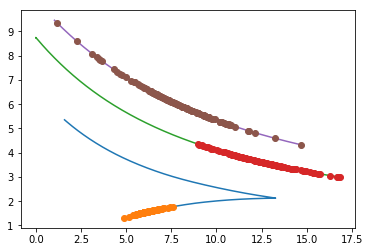

[ -1.26490183e-03  -9.94635446e-01   1.98367727e+01]


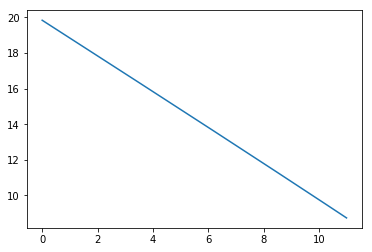

In [4]:
ex_D = linspace(0, 11., 1001)
ex_P = linspace(0, 20., 1001)
ex_T = linspace(0, 8.5, 1001)

# Now we have beam energy:
Ebeam = 27.36 # Proton energy [MeV]
Twidth = 4.56 # Target thickness [mg/cm^2]

Fwidth = 10 # Al-absorber width [um]
dEwidth = 309 # delta-E detector width [um]
Ewidth = 1041 # E detector width [um] 

th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[0]

e, de = SimulateNiPP(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex_P, th)
plt.plot(e, de)

e, de = SimulateNiPP(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states64Ni.txt")*1e-3, th)
plt.plot(e, de, "o")

e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex_D, th)
plt.plot(e, de)

e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states63Ni.txt")*1e-3, th)
plt.plot(e[e>0], de[e>0], "o")

e, de = SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex_T, th)
plt.plot(e, de)

e, de = SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states62Ni.txt")*1e-3, th)
plt.plot(e[e>0], de[e>0], "o")

plt.show()

e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex_D, th)
plt.plot(ex_D, e+de)
print polyfit(ex_D, e+de, 2)
plt.show()



#for i in range(48):
    #th = ScatteringAngle(i, 22.0, 11.0, 0.491, 0.5)[0]
    #e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex_D, th)
    #p = polyfit(e+de, ex_D, 2)
    #print "%i: %1.3f, %2.6f %2.6f %2.6f" % (i, th*180./pi, p[2], p[1], p[0])
    #print "%2.6f %2.6f %2.6f \\" % (p[2], p[1], p[0])


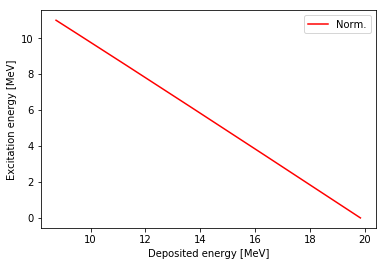

In [5]:
ex = linspace(0, 11., 1001)

# Now we have beam energy:
Ebeam = 27.36 # Proton energy [MeV]
Twidth = 4.56 # Target thickness [mg/cm^2]

Fwidth = 10 # Al-absorber width [um]
dEwidth = 309 # delta-E detector width [um]
Ewidth = 1041 # E detector width [um] 


th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[0]
de, e = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex, th)
plt.plot(e+de, ex, "r", label="Norm.")

a = de+e

th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[1]
de, e = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex, th)
#plt.plot(ex, e+de, "g", label="th. min.")

b = de+e

#plt.plot(ex, a-b)
#plt.show()

th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[2]
de, e = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex, th)
#plt.plot(ex, e+de, "b", label="th. max.")

plt.legend(loc="best")
plt.xlabel("Deposited energy [MeV]")
plt.ylabel("Excitation energy [MeV]")
plt.show()

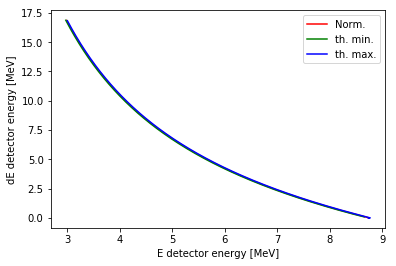

In [6]:
ex = linspace(0, 11., 1001)

# Now we have beam energy:
Ebeam = 27.36 # Proton energy [MeV]
Twidth = 4.56 # Target thickness [mg/cm^2]

Fwidth = 10 # Al-absorber width [um]
dEwidth = 309 # delta-E detector width [um]
Ewidth = 1041 # E detector width [um] 


th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[0]
de, e = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex, th)
plt.plot(e, de, "r", label="Norm.")

th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[1]
de, e = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex, th)
plt.plot(e, de, "g", label="th. min.")

th = ScatteringAngle(0, 22.0, 11.0, 0.491, 0.5)[2]
de, e = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ex, th)
plt.plot(e, de, "b", label="th. max.")

plt.legend(loc="best")
plt.xlabel("E detector energy [MeV]")
plt.ylabel("dE detector energy [MeV]")
plt.show()

In [3]:
# Now we will make table of excitation energy, dE energy, E energy and total energy deposited.

# Now we have beam energy:
Ebeam = 27.36 # Proton energy [MeV]
Twidth = 4.56 # Target thickness [mg/cm^2]

Fwidth = 10 # Al-absorber width [um]
dEwidth = 309 # delta-E detector width [um]
Ewidth = 1041 # E detector width [um] 

th = ScatteringAngle(14, 22.0, 11.0, 0.491, 0.5)[0]

e, de = SimulateNiPP(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states64Ni.txt")*1e-3, th)
ex = ReadStates("states64Ni.txt")
print "Excitation energy [keV] | dE energy [keV] | E energy [keV] | dE+E energy [keV]"
for i in range(len(ex)):
    print "%3.2f | %2.6f | %2.6f | %2.6f" % (ex[i], de[i]*1e3, e[i]*1e3, (de[i]+e[i])*1e3)
print "\n\n\n\n"

e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states63Ni.txt")*1e-3, th)
ex = ReadStates("states63Ni.txt")
print "Excitation energy [keV] | dE energy [keV] | E energy [keV] | dE+E energy [keV]"
for i in range(len(ex)):
    print "%3.2f | %2.6f | %2.6f | %2.6f" % (ex[i], de[i]*1e3, e[i]*1e3, (de[i]+e[i])*1e3)
print "\n\n\n\n"

e, de = SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states62Ni.txt")*1e-3, th)
ex = ReadStates("states62Ni.txt")
print "Excitation energy [keV] | dE energy [keV] | E energy [keV] | dE+E energy [keV]"
for i in range(len(ex)):
    print "%3.2f | %2.6f | %2.6f | %2.6f" % (ex[i], de[i]*1e3, e[i]*1e3, (de[i]+e[i])*1e3)


Excitation energy [keV] | dE energy [keV] | E energy [keV] | dE+E energy [keV]
0.00 | 1411.125561 | 5314.124550 | 6725.250111
1345.75 | 1471.789946 | 5616.112147 | 7087.902094
2276.56 | 1522.963433 | 5848.483440 | 7371.446874
2485.00 | 1535.066511 | 5903.521377 | 7438.587887
2610.10 | 1542.330907 | 5937.352054 | 7479.682960
2867.30 | 1557.267277 | 6008.785067 | 7566.052344
2972.08 | 1563.352592 | 6038.609707 | 7601.962299
3025.83 | 1566.474332 | 6054.071609 | 7620.545941
3166.10 | 1574.621369 | 6094.940465 | 7669.561833
3275.98 | 1581.003639 | 6127.478108 | 7708.481747
3395.70 | 1587.957778 | 6163.452330 | 7751.410107
3463.61 | 1591.902595 | 6184.100481 | 7776.003076
3482.00 | 1592.970868 | 6189.722115 | 7782.692983
3560.40 | 1597.525208 | 6213.832334 | 7811.357542
3647.98 | 1602.612997 | 6241.041568 | 7843.654565
3749.00 | 1608.481786 | 6272.787592 | 7881.269378
3749.40 | 1608.505025 | 6272.914065 | 7881.419089
3797.00 | 1611.270447 | 6288.007417 | 7899.277865
3808.00 | 1611.909524 | 

Excitation energy [keV] | dE energy [keV] | E energy [keV] | dE+E energy [keV]
0.00 | 4699.133007 | 14205.210770 | 18904.343777
1172.98 | 4995.281137 | 12746.994991 | 17742.276128
2048.68 | 5251.393494 | 11621.576563 | 16872.970056
2301.84 | 5332.625770 | 11288.850977 | 16621.476746
2336.52 | 5344.040767 | 11242.977684 | 16587.018451
2890.63 | 5535.107102 | 10500.702282 | 16035.809384
3058.76 | 5596.435586 | 10271.964064 | 15868.399650
3157.96 | 5633.673838 | 10135.931505 | 15769.605343
3176.70 | 5640.796627 | 10110.143732 | 15750.940359
3257.62 | 5671.874910 | 9998.463392 | 15670.338302
3262.00 | 5673.572006 | 9992.403227 | 15665.975233
3269.97 | 5676.664055 | 9981.371913 | 15658.035969
3277.69 | 5679.663944 | 9970.681706 | 15650.345650
3369.98 | 5715.895498 | 9842.508051 | 15558.403549
3378.00 | 5719.076193 | 9831.336982 | 15550.413175
3462.00 | 5752.699607 | 9714.017997 | 15466.717605
3486.00 | 5762.410087 | 9680.392521 | 15442.802608
3518.23 | 5775.523169 | 9635.162202 | 15410.6853

[    2.69607834  1126.1956859 ]


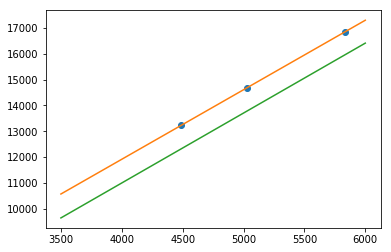

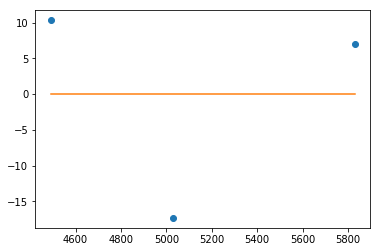

In [9]:
ch = array([5.83E+03,5.03E+03,4.49E+03])
ex = array([16851.31101,14670.15238,13241.92612])

ch = array([5.86448e+03,5.09801e+03,4.57121e+03])
ex = array([16830.569588,14640.032204,13209.962576])

p = polyfit(ch, ex, 1)
print p

plt.plot(ch, ex, "o")
plt.plot(linspace(3500, 6000, 1001), p[0]*linspace(3500, 6000, 1001)+p[1])
plt.plot(linspace(3500, 6000, 1001), 2.71185596591*linspace(3500, 6000, 1001)+143.674174063)
plt.show()

plt.plot(ch, ex - p[0]*ch - p[1], "o")
plt.plot(ch, [0,0,0])

[ 6014.42  5999.11  5981.23  5964.63  5948.91  5934.    5917.42  5897.86
  5873.97  5858.35  5846.12  5825.9   5798.53]


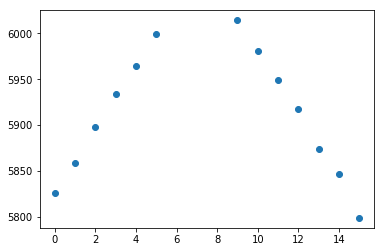

In [38]:
n = array(range(0, 15))
e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, ReadStates("states63Ni.txt")*1e-3, th)

n = array([0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14,15])
x = array([5825.9,5858.35,5897.86,5934,5964.63,5999.11,6014.42,5981.23,5948.91,5917.42,5873.97,5846.12,5798.53])

y = copy(x[x.argsort()])
print y[::-1]

plt.plot(n, x, "o")

3: 28.610 - 16788.106 keV
4: 29.110 - 16766.396 keV
5: 29.604 - 16744.374 keV
6: 30.094 - 16722.046 keV
7: 30.579 - 16699.418 keV
8: 31.059 - 16676.495 keV
9: 31.535 - 16653.282 keV
10: 32.005 - 16629.785 keV
11: 32.471 - 16606.009 keV
12: 32.932 - 16581.959 keV
13: 33.389 - 16557.641 keV
14: 33.840 - 16533.058 keV
15: 34.287 - 16508.217 keV
[  1.32135398e+00   8.83899412e+03]


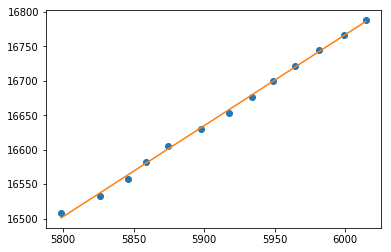

[  3.74121237e+00   2.05866189e-01   4.23361458e+00   2.76949199e+00
   3.70109507e-02   1.16563421e+01   2.22666939e+01   5.61667437e+00
   2.93907150e+01   4.04468325e+00   3.77886663e+01   1.60951245e+01
   5.34681854e+01]
191.314280843   17.3922073494


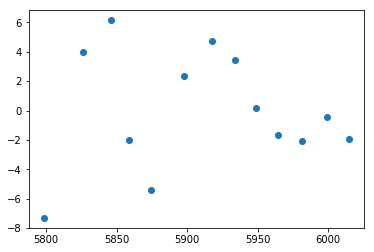

In [53]:
e_gs = zeros(16-3)
for i in range(3,16):
    th = ScatteringAngle(i, 22.0, 11.0, 0.491, 0.5)[0]
    e, de = SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)
    e_gs[i-3] = e
    print "%d: %2.3f - %2.3f keV" % (i, th*180./pi, e*1e3)

e_found = y[::-1]
p = polyfit(e_found, e_gs*1e3, 1)
print p
plt.plot(e_found, e_gs*1e3, "o")
plt.plot(linspace(e_found[0],e_found[-1],1001),p[0]*linspace(e_found[0],e_found[-1],1001)+p[1])
plt.show()
print ( e_found*p[0]+p[1]-e_gs*1e3 )**2
chi2 = sum((e_found*p[0]+p[1]-e_gs*1e3)**2)
print chi2, " ", chi2/(len(e_found)-2)

plt.plot(e_found,e_found*p[0]+p[1]-e_gs*1e3,"o")
#plt.plot(e_found, zeros(len(e_found)))
plt.show()

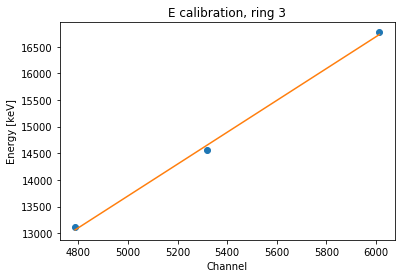

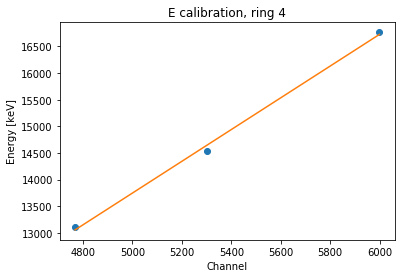

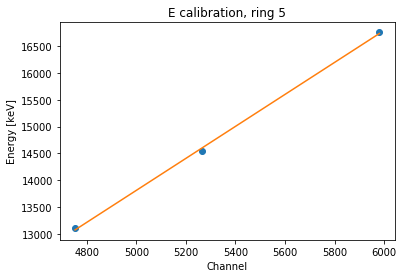

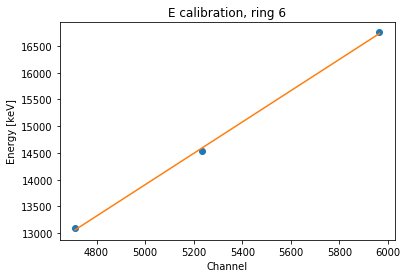

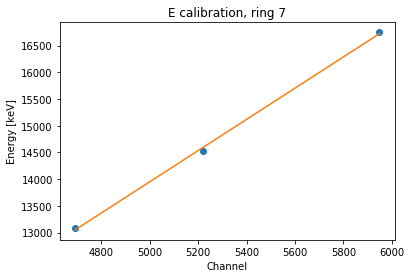

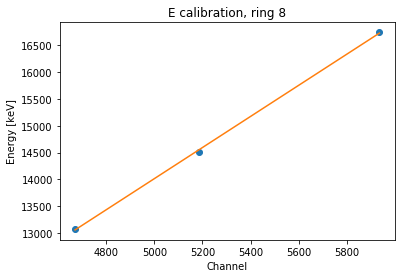

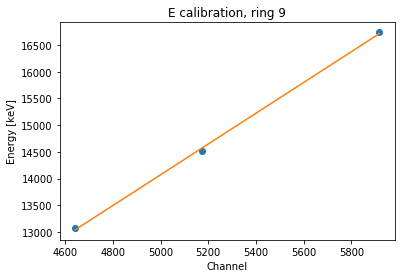

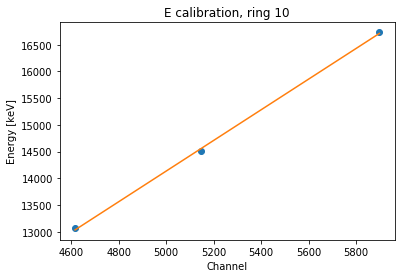

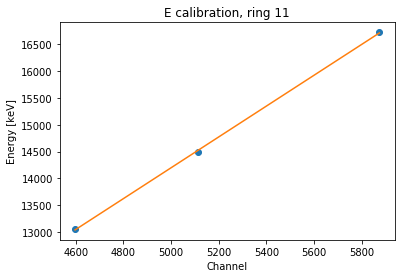

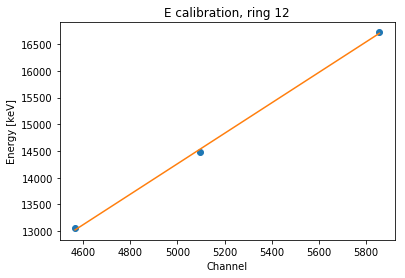

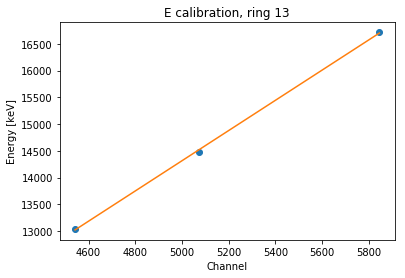

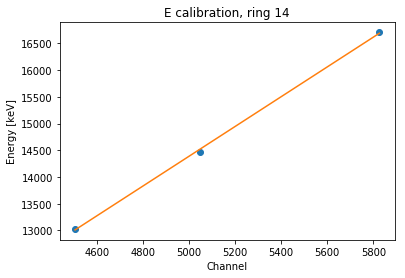

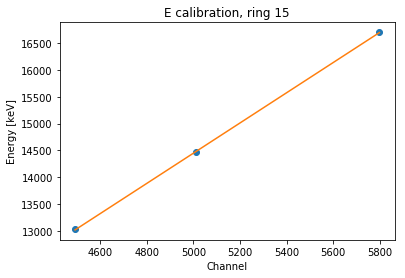

Gain: 2.891987, Chi2: 0.004283


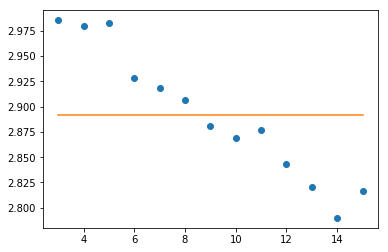

Gain: -386.885993, Chi2: 322508.928199


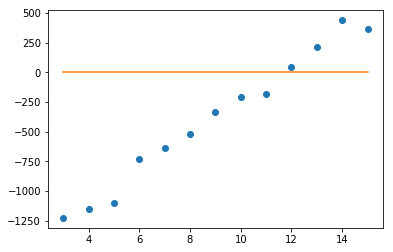

[  2.82268081 -18.49454202]


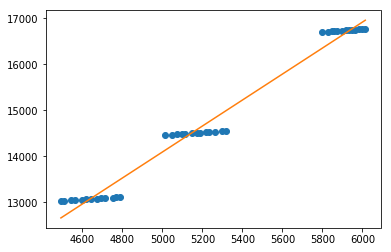

In [75]:
def CalcGainShift(ringNo,ch):
    th=ScatteringAngle(ringNo, 22.0, 11.0, 0.491, 0.5)[0]
    energy = array([SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)[0],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)[0],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 1172.98*1e-3, th)[0]])*1e3
    
    p = polyfit(ch, energy, 1)
    
    plt.title("E calibration, ring %i" % ( ringNo ) )
    plt.plot(ch, energy, "o")
    plt.plot(linspace(ch[0],ch[-1],1001), p[0]*linspace(ch[0],ch[-1],1001)+p[1])
    plt.xlabel("Channel")
    plt.ylabel("Energy [keV]")
    plt.show()
    return p[0], p[1], energy, ch

gain = []
shift = []

en = []
ch = []

# From ring 3:
g,s,e,c = CalcGainShift(3, array([6014.42,5319.01,4786.14]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 4:
g,s,e,c = CalcGainShift(4, array([5999.11,5299.95,4767.83]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 5:
g,s,e,c = CalcGainShift(5, array([5981.23,5262.88,4752.04]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 6:
g,s,e,c = CalcGainShift(6, array([5964.63,5233.44,4711.66]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 7:
g,s,e,c = CalcGainShift(7, array([5948.91,5218.15,4690.67]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 8:
g,s,e,c = CalcGainShift(8, array([5934,5186.98,4671.18]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 9:
g,s,e,c = CalcGainShift(9, array([5917.42,5173.78,4641.68]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 10:
g,s,e,c = CalcGainShift(10, array([5897.86,5146.37,4616.54]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 11:
g,s,e,c = CalcGainShift(11, array([5873.97,5113.79,4596.73]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 12:
g,s,e,c = CalcGainShift(12, array([5858.35,5096.29,4564.51]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 13:
g,s,e,c = CalcGainShift(13, array([5846.12,5071.68,4541.8]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 14:
g,s,e,c = CalcGainShift(14, array([5825.9,5046.41,4506.22]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 15:
g,s,e,c = CalcGainShift(15, array([5798.53,5011.39,4492.25]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

gfinal = sum(gain)/float(len(gain))
chiGain = sum((gfinal - gain)**2)/float(len(gain)-1)
print "Gain: %2.6f, Chi2: %2.6f" % ( gfinal, chiGain )
plt.plot(range(3,16),gain, "o")
plt.plot(range(3,16),ones(len(gain))*gfinal)
plt.show()

sfinal = sum(shift)/float(len(shift))
chiShift = sum((sfinal - shift)**2)/float(len(shift)-1)

print "Gain: %2.6f, Chi2: %2.6f" % ( sfinal, chiShift )
plt.plot(range(3,16),shift, "o")
plt.plot(range(3,16),ones(len(shift))**sfinal)
plt.show()

p = polyfit(ch, en, 1)
print p
plt.plot(ch, en,"o")
plt.plot(linspace(ch[0],ch[-1],1001),p[0]*linspace(ch[0],ch[-1],1001)+p[1])
plt.show()

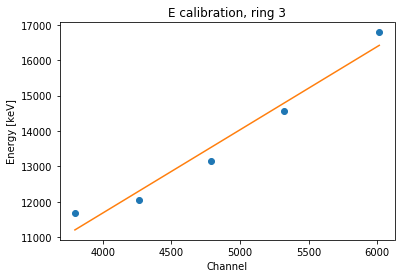

2.35082172558 2279.71807455 210136.191827


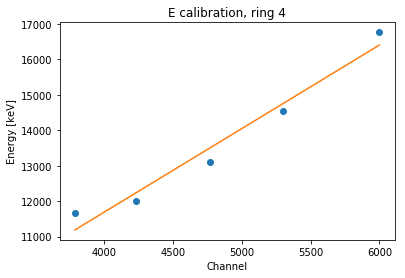

2.36000708746 2245.35927985 201162.032176


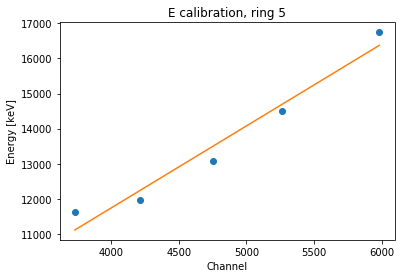

2.33618410618 2397.34772033 226266.16322


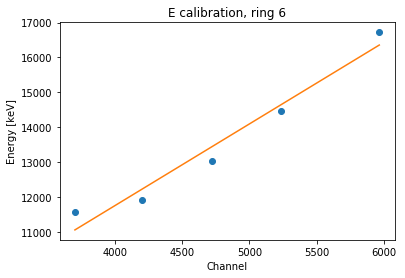

2.33784591377 2411.86917145 228404.98247


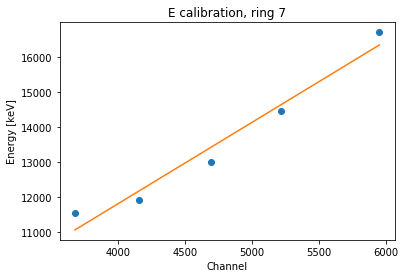

2.32505656098 2503.02025231 216056.035651


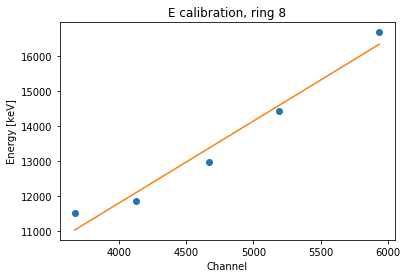

2.34445144955 2421.22826042 196457.835413


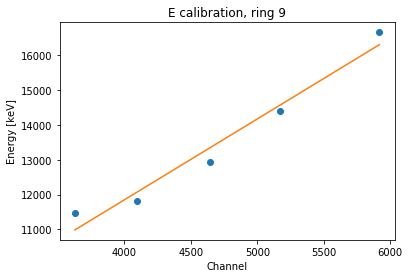

2.31912421352 2572.045549 206991.526937


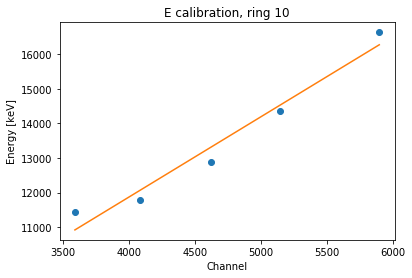

2.31901515239 2590.93143868 220838.17814


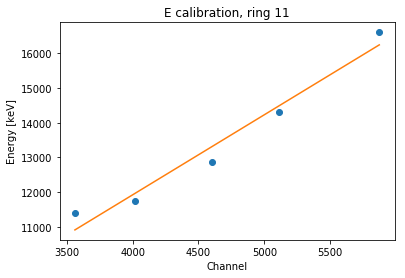

2.30542248496 2700.34658837 212646.032117


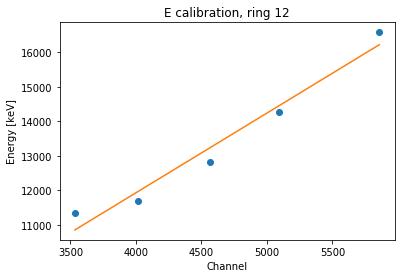

2.30918059301 2692.35870512 216733.809167


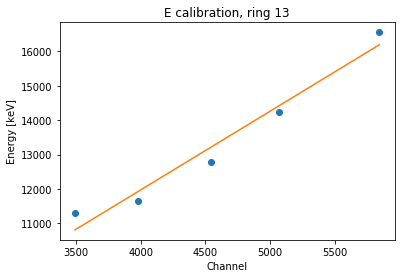

2.28659441253 2824.90214908 221310.742084


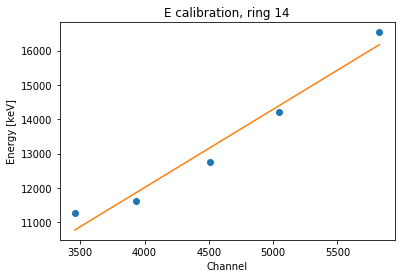

2.27825077562 2896.94102847 214795.370117


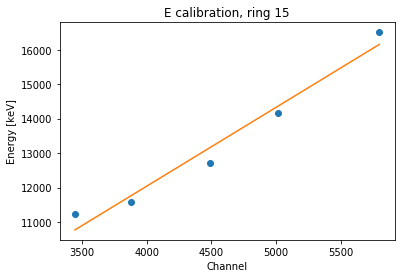

2.28874188986 2882.50566137 199379.352021
Gain: 2.320054, Chi2: 0.000660


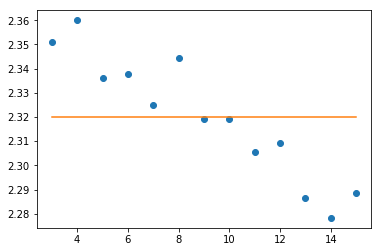

Gain: 2570.659529, Chi2: 47751.045810


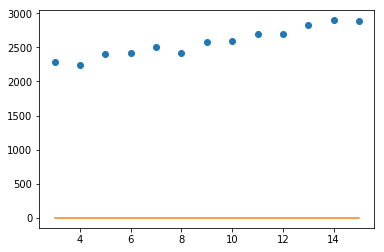

[  2.30464486e+00   2.64516135e+03]


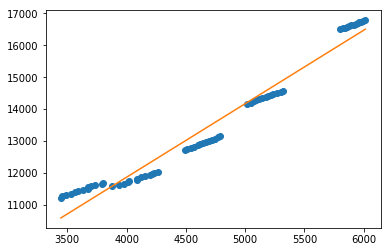

In [143]:
def CalcGainShift(ringNo,ch):
    th=ScatteringAngle(ringNo, 22.0, 11.0, 0.491, 0.5)[0]
    energy = array([SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)[0],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)[0],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 1172.98*1e-3, th)[0],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 2048.68*1e-3, th)[0],
                    (SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 2301.84*1e-3, th)[0]+
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 2336.52*1e-3, th)[0])*0.5
                    ])*1e3
    
    p = polyfit(ch, energy, 1)
    
    plt.title("E calibration, ring %i" % ( ringNo ) )
    plt.plot(ch, energy, "o")
    plt.plot(linspace(ch[0],ch[-1],1001), p[0]*linspace(ch[0],ch[-1],1001)+p[1])
    plt.xlabel("Channel")
    plt.ylabel("Energy [keV]")
    plt.show()
    print p[0], p[1], sum((energy - ch*p[0] - p[1])**2)/(len(energy) - 2)
    return p[0], p[1], energy, ch

gain = []
shift = []

en = []
ch = []

# From ring 3:
g,s,e,c = CalcGainShift(3, array([6014.42,5320.45,4785.83,4262.33,3798.61]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 4:
g,s,e,c = CalcGainShift(4, array([5999.11,5299.19,4773.43,4231.45,3790.05]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 5:
g,s,e,c = CalcGainShift(5, array([5981.23,5265.53,4749.78,4216.06,3732.2]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 6:
g,s,e,c = CalcGainShift(6, array([5964.63,5235.59,4722.08,4201.38,3703.22]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 7:
g,s,e,c = CalcGainShift(7, array([5948.91,5218.03,4694.27,4152.38,3677.11]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 8:
g,s,e,c = CalcGainShift(8, array([5934,5191.19,4671.9,4125.9,3674.49]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 9:
g,s,e,c = CalcGainShift(9, array([5917.42,5173.78,4644.72,4092,3628.64]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 10:
g,s,e,c = CalcGainShift(10, array([5897.86,5146.37,4620.58,4084.2,3593.46]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 11:
g,s,e,c = CalcGainShift(11, array([5873.97,5115.53,4599.44,4016.72,3561.23]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 12:
g,s,e,c = CalcGainShift(12, array([5858.35,5095.49,4569.41,4012.18,3534.29]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 13:
g,s,e,c = CalcGainShift(13, array([5846.12,5071.68,4543.17,3977.01,3491.29]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 14:
g,s,e,c = CalcGainShift(14, array([5825.9,5046.41,4510.02,3934.34,3458.72]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 15:
g,s,e,c = CalcGainShift(15, array([5798.53,5012.29,4488.84,3876.61,3445.92]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

gfinal = sum(gain)/float(len(gain))
chiGain = sum((gfinal - gain)**2)/float(len(gain)-1)
print "Gain: %2.6f, Chi2: %2.6f" % ( gfinal, chiGain )
plt.plot(range(3,16),gain, "o")
plt.plot(range(3,16),ones(len(gain))*gfinal)
plt.show()

sfinal = sum(shift)/float(len(shift))
chiShift = sum((sfinal - shift)**2)/float(len(shift)-1)

print "Shift: %2.6f, Chi2: %2.6f" % ( sfinal, chiShift )
plt.plot(range(3,16),shift, "o")
plt.plot(range(3,16),ones(len(shift))**sfinal)
plt.show()

p = polyfit(ch, en, 1)
print p
plt.plot(ch, en,"o")
plt.plot(linspace(ch[0],ch[-1],1001),p[0]*linspace(ch[0],ch[-1],1001)+p[1])
plt.show()

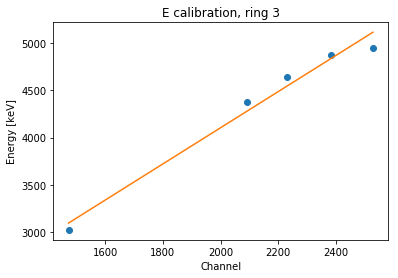

1.91735264655 269.265482626 17297.2796152


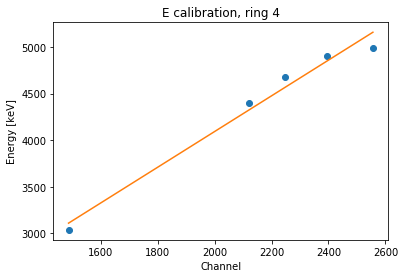

1.91383307678 265.539401586 18832.0525783


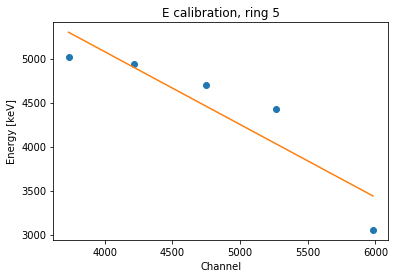

-0.827096810117 8386.69600754 148912.693517


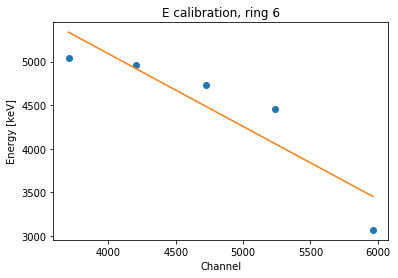

-0.832589725755 8419.19263571 148333.450425


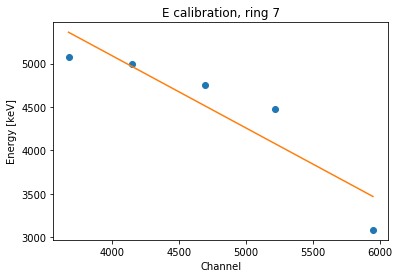

-0.83112469678 8415.83839992 149111.156184


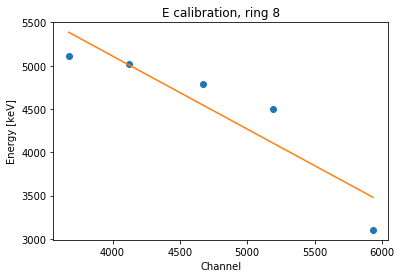

-0.843386538099 8484.92018026 145161.756368


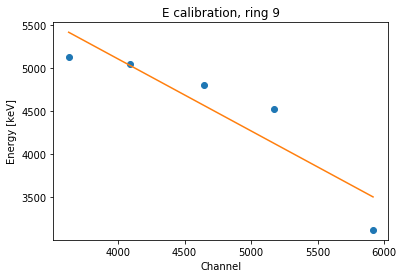

-0.836978810858 8458.23415313 149779.697572


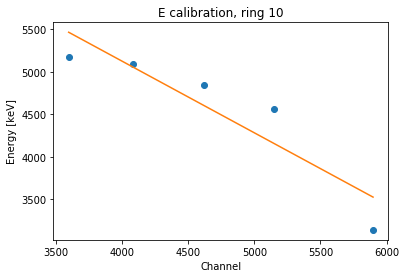

-0.841303367667 8486.90339767 151988.463411


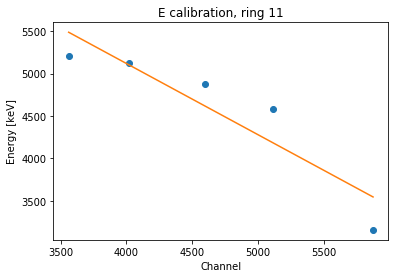

-0.839592460461 8477.44139626 153463.884668


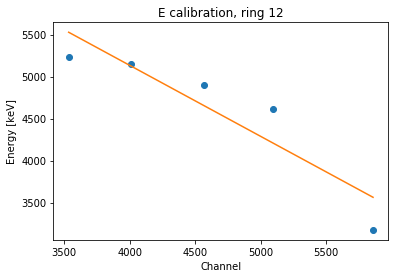

-0.84545754241 8516.62122546 154331.030953


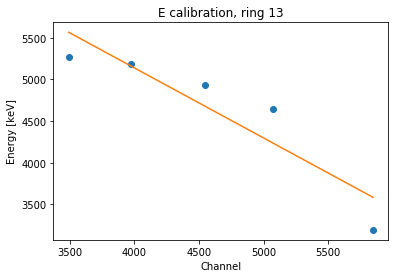

-0.841078223996 8501.64819368 156432.902623


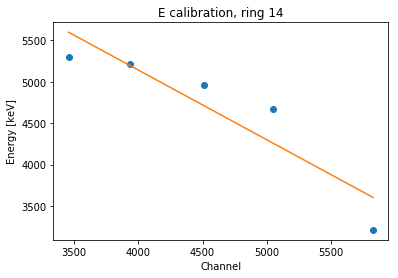

-0.841860430414 8508.60510208 157190.061124


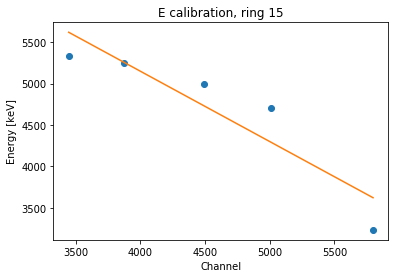

-0.850010698517 8549.38164507 156027.308938
Gain: -0.415330, Chi2: 1.070214


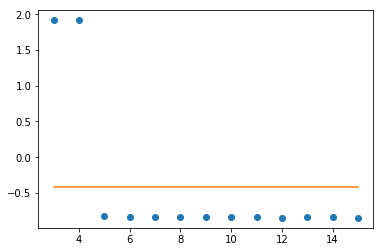

Shift: 7210.791325, Chi2: 9498038.292216


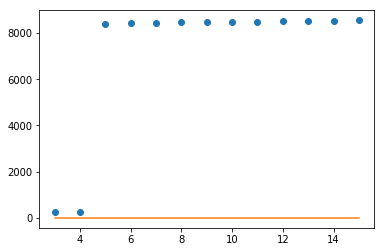

[ -2.66707149e-01   5.67515041e+03]


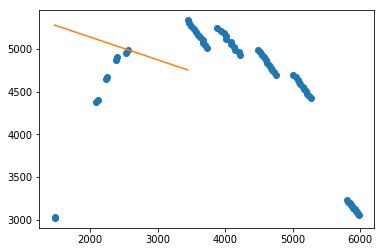

In [147]:
def CalcGainShift(ringNo,ch):
    th=ScatteringAngle(ringNo, 22.0, 11.0, 0.491, 0.5)[1]
    energy = array([SimulateNiPD(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)[1],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 0, th)[1],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 1172.98*1e-3, th)[1],
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 2048.68*1e-3, th)[1],
                    (SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 2301.84*1e-3, th)[1]+
                    SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 0.5, 2336.52*1e-3, th)[1])*0.5
                    ])*1e3
    
    p = polyfit(ch, energy, 1)
    
    plt.title("E calibration, ring %i" % ( ringNo ) )
    plt.plot(ch, energy, "o")
    plt.plot(linspace(ch[0],ch[-1],1001), p[0]*linspace(ch[0],ch[-1],1001)+p[1])
    plt.xlabel("Channel")
    plt.ylabel("Energy [keV]")
    plt.show()
    print p[0], p[1], sum((energy - ch*p[0] - p[1])**2)/(len(energy) - 2)
    return p[0], p[1], energy, ch

gain = []
shift = []

en = []
ch = []

# From ring 3:
g,s,e,c = CalcGainShift(3, array([1472.99,2092.6,2232.06,2381.77,2528.54]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 4:
g,s,e,c = CalcGainShift(4, array([1486.03,2118.76,2247.58,2394,2556.15]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 5:
g,s,e,c = CalcGainShift(5, array([5981.23,5265.53,4749.78,4216.06,3732.2]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 6:
g,s,e,c = CalcGainShift(6, array([5964.63,5235.59,4722.08,4201.38,3703.22]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 7:
g,s,e,c = CalcGainShift(7, array([5948.91,5218.03,4694.27,4152.38,3677.11]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 8:
g,s,e,c = CalcGainShift(8, array([5934,5191.19,4671.9,4125.9,3674.49]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 9:
g,s,e,c = CalcGainShift(9, array([5917.42,5173.78,4644.72,4092,3628.64]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 10:
g,s,e,c = CalcGainShift(10, array([5897.86,5146.37,4620.58,4084.2,3593.46]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 11:
g,s,e,c = CalcGainShift(11, array([5873.97,5115.53,4599.44,4016.72,3561.23]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 12:
g,s,e,c = CalcGainShift(12, array([5858.35,5095.49,4569.41,4012.18,3534.29]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 13:
g,s,e,c = CalcGainShift(13, array([5846.12,5071.68,4543.17,3977.01,3491.29]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 14:
g,s,e,c = CalcGainShift(14, array([5825.9,5046.41,4510.02,3934.34,3458.72]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

# From ring 15:
g,s,e,c = CalcGainShift(15, array([5798.53,5012.29,4488.84,3876.61,3445.92]))
for i in range(len(e)):
    en.append(e[i])
    ch.append(c[i])
gain.append(g)
shift.append(s)

gfinal = sum(gain)/float(len(gain))
chiGain = sum((gfinal - gain)**2)/float(len(gain)-1)
print "Gain: %2.6f, Chi2: %2.6f" % ( gfinal, chiGain )
plt.plot(range(3,16),gain, "o")
plt.plot(range(3,16),ones(len(gain))*gfinal)
plt.show()

sfinal = sum(shift)/float(len(shift))
chiShift = sum((sfinal - shift)**2)/float(len(shift)-1)

print "Shift: %2.6f, Chi2: %2.6f" % ( sfinal, chiShift )
plt.plot(range(3,16),shift, "o")
plt.plot(range(3,16),ones(len(shift))**sfinal)
plt.show()

p = polyfit(ch, en, 1)
print p
plt.plot(ch, en,"o")
plt.plot(linspace(ch[0],ch[-1],1001),p[0]*linspace(ch[0],ch[-1],1001)+p[1])
plt.show()

0.590620398615 0.582882080776 0.598279246898


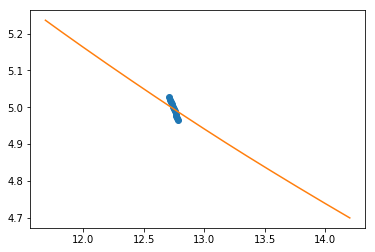

12.7848743028 12.7086683858


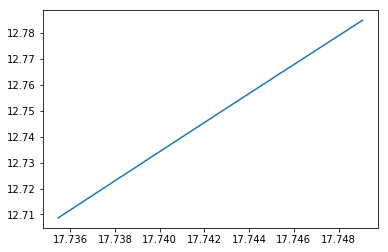

In [135]:
def SimulateNiPT(Ebeam, Twidth, Fwidth, dEwidth, Ewidth, ex, theta):
    """
    Ebeam: energy of the incomming beam in MeV
    Twidth: Thickness of the target in g/cm2
    Fwidth: Thickness of the absorber in um
    dEwidth: Thickness of the dE detector in um
    Ewidth: Thickness of the E detector in um
    reactionPoint: Fraction of target thickness where the reaction will take place.
    ex: Array with excitation energy.
    theta: Angle of outgoing ion.
    """
    
    # Define masses
    m1 = 63.9279660*931.494061 # Mass nickel 64
    m2 = 1.008*931.494061 # Proton mass
    m3 = 3.0160492*931.494061 # Deuteron mass
    m4 = 61.9283451*931.494061 # Mass nickel 63
    
    # Required stopping power
    stopTargetP = StoppingPowerFile("protonNi.txt")
    stopTargetT = StoppingPowerFile("tritonNi.txt")
    stopAbsorberT = StoppingPowerFile("StAl_table_um.txt")
    stopTelescopeT = StoppingPowerFile("StSi_table_um.txt")
    
    # First we calculate the point where the interaction will happend.
    thick_react = Twidth*0.5 # reactionPoint is a number between 0 and 1.
    
    Ereaction = Ebeam
    Ereaction = stopTargetP.Loss(Ereaction, thick_react, 1001)
    Ereaction = T3Energy(m1, m2, m3, m4, Ereaction, ex, theta)
    Ereaction = stopTargetT.Loss(Ereaction, (Twidth-thick_react)/cos(theta), 1001)
        
    EaA = stopAbsorberT.Loss(Ereaction, Fwidth/cos(theta), 1001)
    EaDE = stopTelescopeT.Loss(EaA, dEwidth/cos(theta), 1001)
    EaE = stopTelescopeT.Loss(EaDE, Ewidth/cos(theta), 1001)
    EinDE = EaA - EaDE
    EinE = EaDE - EaE
    return EinE, EinDE

# Now we have beam energy:
Ebeam = 27.36 # Proton energy [MeV]
Twidth = 4.56 # Target thickness [mg/cm^2]

Fwidth = 10 # Al-absorber width [um]
dEwidth = 309 # delta-E detector width [um]
Ewidth = 1041 # E detector width [um] 

th, th_min, th_max = ScatteringAngle(14, 22.0, 11.0, 0.491, 0.5)
print th, th_min, th_max
th_r = linspace(th_min, th_max, 11)
e = zeros(len(th_r))
de = zeros(len(th_r))
for i in range(len(th_r)):
    e[i], de[i] = SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, 1172.98*1e-3, th_r[i])
    #print e[i], de[i]
plt.plot(e, de,"o")
e_a,de_a = SimulateNiPT(Ebeam, Twidth*1e-3, Fwidth, dEwidth, Ewidth, linspace(0, 2.,1001), th)
plt.plot(e_a,de_a)
plt.show()
print e[0], e[-1]
plt.plot(e+de,e)
plt.show()

[  2.21013644e+01  -9.77446996e+04]


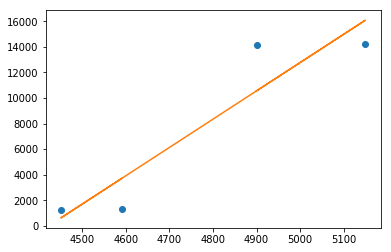

In [140]:
p=polyfit([4900,5150,4450.5,4590.5],[14169,14240,1270.86,1278.49],1)
print p
plt.plot([4900,5150,4450.5,4590.5],[14169,14240,1270.86,1278.49],"o")
plt.plot([4900,5150,4450.5,4590.5],p[0]*array([4900,5150,4450.5,4590.5])+p[1])